The goal in this first cycle is to perform clustering using basic features, where the result will provide the basis for checking progress.

# 0.0 IMPORTS

In [1]:
import re 
import numpy                 as np
import pandas                as pd

import seaborn               as sns
import matplotlib.patches    as mpatches
import scikitplot            as skplt
import plotly.express        as px
import umap.umap_            as umap

from sklearn import cluster  as c
from sklearn import metrics  as m

from matplotlib              import pyplot as plt
from IPython.core.display    import HTML
from IPython.display         import Image

from sklearn                 import preprocessing as pp
from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Helper Functions

In [2]:
def personal_settings():   
    display(HTML('<style>.container{width:80% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.mode.chained_assignment = None
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20,10]
    plt.rcParams['font.size'] = 24
    
    sns.set()

In [3]:
personal_settings()

## 0.2 Load Data

In [4]:
df_raw = pd.read_csv('../data/OnlineRetail.csv')

# 1 DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

In [6]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


## 1.1 Data Dimensions

In [7]:
print(df1.shape[0], 'rows')
print(df1.shape[1], 'columns')

541909 rows
8 columns


## 1.2 Rename columns

In [8]:
df1.columns 

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [9]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date','unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data Descriptions

* `invoice_no` | A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter `c`, it indicates a cancellation. 
* `stock_code` | A 5-digit integral number uniquely assigned to each distinct product.   
* `description` | Product name. 
* `quantity` | The quantities of each product (item) per transaction.  
* `invoice_date` | The day and time when each transaction was generated.    
* `unit_price` | Product price per unit in sterling.
* `customer_iD` | A 5-digit integral number uniquely assigned to each customer.    
* `country` | The name of the country where each customer resides.   

## 1.3 Data Types

In [10]:
description = []

for i in df1.columns:
    description.append([
        i,
        df1[i].dtypes,
        df1[i].nunique(),
        df1[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(data = description, columns=['attributes', 'dtypes', 'nunique', 'sample'])

,attributes,dtypes,nunique,sample
0,invoice_no,object,25900,"[562925, 568148]"
1,stock_code,object,4070,"[22033, 22918]"
2,description,object,4223,"[BROWN VINTAGE VICTORIAN EARRINGS, SET OF 4 FA..."
3,quantity,int64,722,"[123, 120]"
4,invoice_date,object,23260,"[2011-02-24 10:05:00, 2010-12-03 17:20:00]"
5,unit_price,float64,1630,"[4.21, 109.25]"
6,customer_id,float64,4372,"[12598.0, 14535.0]"
7,country,object,38,"[Italy, Brazil]"


## 1.4 Check NA

In [11]:
description = []

for i in df1.columns:
    description.append([
        i,
        df1[i].isna().sum(),
        round((df1[i].isna().sum()/len(df1))*100)
    ])

pd.DataFrame(data = description, columns=['attributes','null', '%null'])

,attributes,null,%null
0,invoice_no,0,0
1,stock_code,0,0
2,description,1454,0
3,quantity,0,0
4,invoice_date,0,0
5,unit_price,0,0
6,customer_id,135080,25
7,country,0,0


## 1.5 Replace NA

As this is the first cycle, our goal is to get a premilinar analysis of possible clusters, we will eliminate the lines with null values, and in another cycle we will think about replacing the null values.

In [12]:
df1.dropna(subset=['description', 'customer_id'], inplace=True)

df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change dtypes

In [13]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date']).dt.normalize()

# customer_id
df1['customer_id'] = np.int64(df1['customer_id'])

In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

In [15]:
df1.head(2)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom


## 1.6 Descriptive Statistics

In [16]:
df_num1 = df1.select_dtypes(include = ['int64', 'float64'])
df_cat1 = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.6.1 Numeric Attributes

In [17]:
# central tendency - mean, median
ct1 = pd.DataFrame(df_num1.apply(np.mean)).T
ct2 = pd.DataFrame(df_num1.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(df_num1.apply(np.std)).T 
d2 = pd.DataFrame(df_num1.apply(min)).T
d3 = pd.DataFrame(df_num1.apply(max)).T
d4 = pd.DataFrame(df_num1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df_num1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df_num1.apply(lambda x: x.kurtosis())).T

# concat
num1_summary = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
num1_summary.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
num1_summary

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,12.06,5.00,248.69,0.18,94317.56
1,unit_price,0.00,38970.00,38970.00,3.46,1.95,69.32,452.22,246924.54
2,customer_id,12346.00,18287.00,5941.00,15287.69,15152.00,1713.60,0.03,-1.18


Can negative `quantity` be a return?     
Can `unit_price` equal to zero be a promotion?

### 1.7.2 Categorical Attributes

In [18]:
df_cat1.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### Invoice No

In [19]:
aux1 = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

display(aux1.sample(5))

print(aux1.shape[0], 'rows')

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
331035,C565962,22975,SPACEBOY CHILDRENS EGG CUP,-1,2011-09-08,1.25,14410,United Kingdom
125652,C547054,M,Manual,-1,2011-03-20,6.95,16444,United Kingdom
52403,C540781,22776,SWEETHEART CAKESTAND 3 TIER,-1,2011-01-11,9.95,16875,United Kingdom
514652,C579739,22567,20 DOLLY PEGS RETROSPOT,-1,2011-11-30,1.45,16956,United Kingdom
41623,C539950,85099B,JUMBO BAG RED RETROSPOT,-10,2010-12-23,1.95,13534,United Kingdom


8905 rows


We know from the data description that `invoice` in what starts with C stands for cancelled.

#### Stock Code

In [20]:
# getting stock_code with just characters
aux2 = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :]

display(aux2.sample(5))

aux2['stock_code'].unique()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
480382,577299,POST,POSTAGE,1,2011-11-18,18.00,12498,Germany
365290,568703,M,Manual,183,2011-09-28,0.08,12748,United Kingdom
368907,569001,POST,POSTAGE,1,2011-09-29,18.00,12703,Germany
263482,C559992,D,Discount,-1,2011-07-14,13.99,14527,United Kingdom
52127,540688,POST,POSTAGE,5,2011-01-11,18.00,12736,France


array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

Some `stock_code` we have an idea of what it means, such as "post", others we don't. Since we know that some do not represent product purchases, we will discard the lines with these categories later on.

#### Country

In [21]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [22]:
len(df1['country'].unique())

37

In [23]:
df1['country'].value_counts(normalize=True).head(10)

United Kingdom   0.89
Germany          0.02
France           0.02
EIRE             0.02
Spain            0.01
Netherlands      0.01
Belgium          0.01
Switzerland      0.00
Portugal         0.00
Australia        0.00
Name: country, dtype: float64

For `country`, that representas the country where purchase was made, we have that the majority was made from the United Kingdom, representing 89%.

In [24]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head(20)

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


# 2 DATA FILTERING

In [25]:
df2 = df1.copy()

In [26]:
# unit_price
df2 = df2.loc[df2['unit_price'] >= 0.04, :] # assuming that less than this value is gift

# categorical attributes
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]

# description
# at this point we will not use the feature description, since it is unlikely to influence the clustering
df2 = df2.drop( columns='description', axis=1)

# country
# For now, we will also not use countries, since 89% of the purchases were made from a single country. 
df2 = df2.drop(columns='country', axis=1)

# 3 FEATURE ENGINEERING

In [27]:
df3 = df2.copy() 

## 3.1 Features Creation

In [28]:
# reference table
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 
                   'invoice_date', 'unit_price'], axis=1).drop_duplicates(ignore_index=True)

df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [29]:
# gross revenue
df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

df_monetary = df3[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# mean ticket
df_mean_ticket = (df3[['customer_id', 'gross_revenue']].groupby('customer_id').mean()
                                                                              .reset_index()                  
                                                                              .rename(columns={'gross_revenue':'mean_ticket'}))

df_ref = pd.merge(df_ref, df_mean_ticket, on='customer_id', how='left')

# quantity of purchase
df_purchases = (df3[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count()
                                                                                           .reset_index()
                                                                                           .rename(columns={'invoice_no': 'qtd_purchases'}))
df_ref = pd.merge(df_ref, df_purchases, on='customer_id', how='left')

# recency
df_recency = df3[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()

df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

In [30]:
df_ref.head()

,customer_id,gross_revenue,mean_ticket,qtd_purchases,recency_days
0,17850,5288.63,16.95,35,302
1,13047,3089.10,15.92,16,46
2,12583,6629.34,28.21,17,2
3,13748,948.25,33.87,5,95
4,15100,635.10,105.85,6,330


# 4 EXPLORATORY DATA ANALYSIS

In [34]:
df4 = df_ref.copy() 

# 5 DATA PREPARATION

In [35]:
df5 = df4.copy()

In [36]:
mms = pp.MinMaxScaler()

df5['gross_revenue'] = mms.fit_transform(df5[['gross_revenue']])
df5['mean_ticket'] = mms.fit_transform(df5[['mean_ticket']])
df5['qtd_purchases'] = mms.fit_transform(df5[['qtd_purchases']])
df5['recency_days'] = mms.fit_transform(df5[['recency_days']])

# 6 FEATURES SELECTION

In [37]:
df6 = df5.copy()

# 7 HYPERPARAMETER FINE TUNNING

In [38]:
df7 = df6.copy()

In [39]:
X = df7.drop(columns=['customer_id'])

clusters = [2, 3, 4, 5, 6, 7]

## 7.1 Within-Cluster Sum of Squares (WSS)

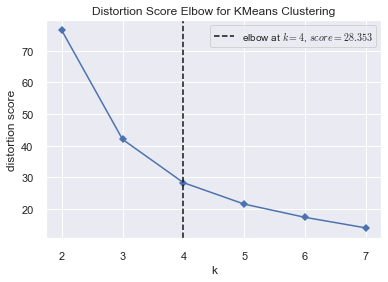

In [40]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2 Silhouette Score

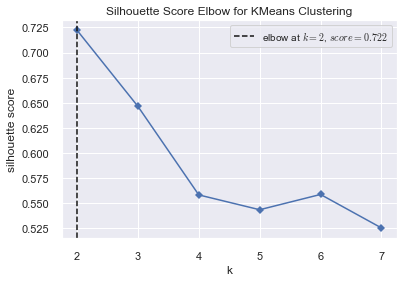

In [41]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)

kmeans.show();

## 7.3 Silhouette Analysis

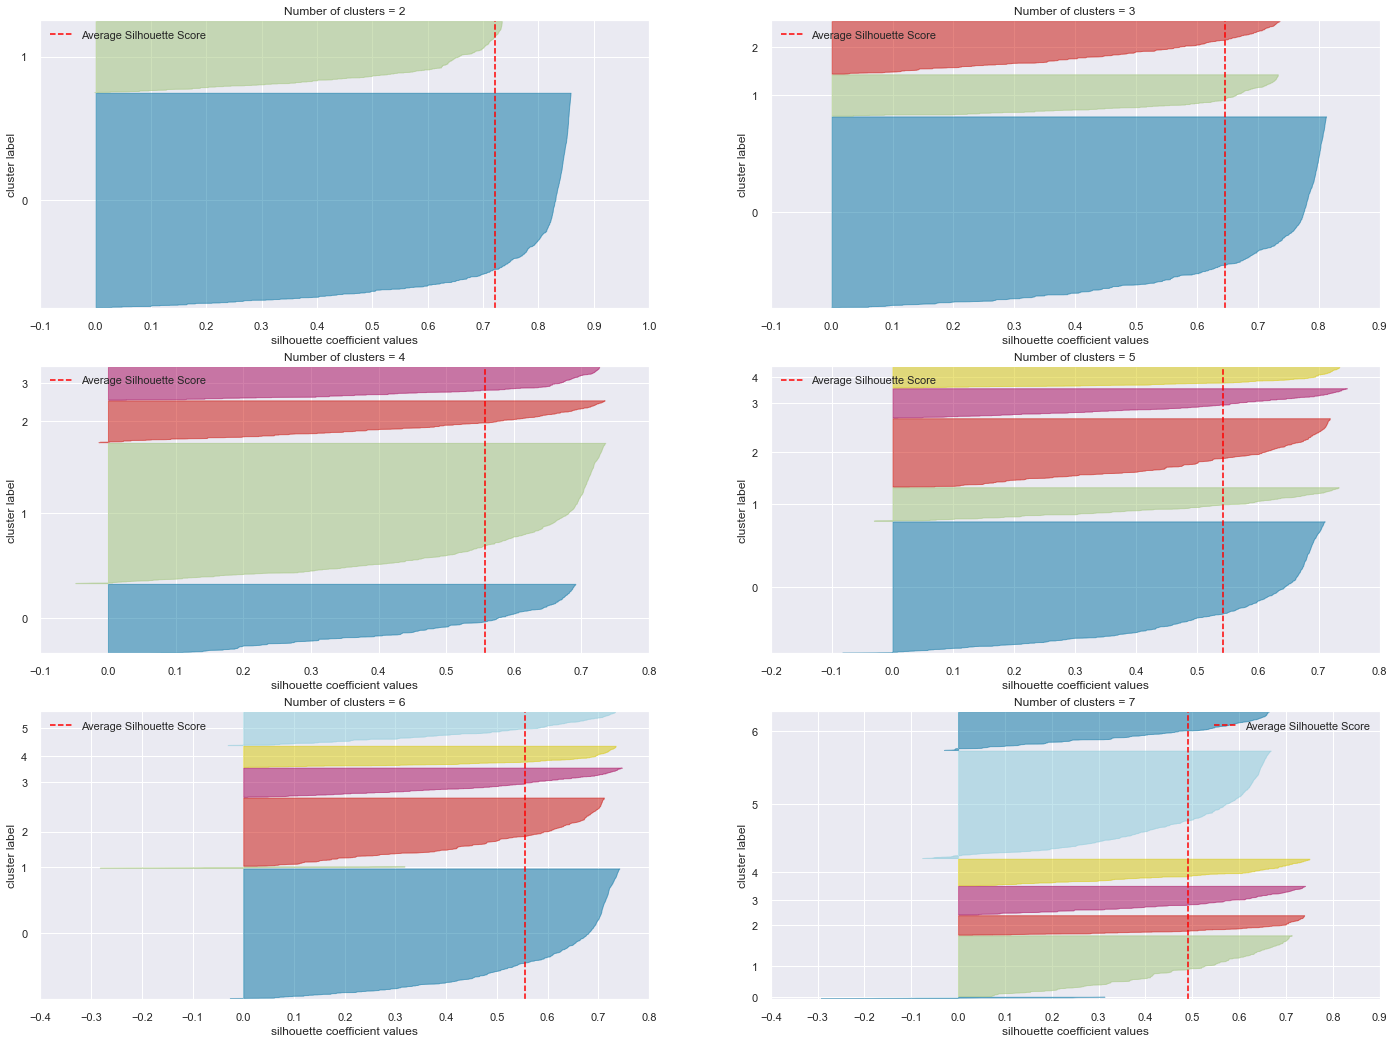

In [42]:
fig, ax = plt.subplots(3, 2, figsize=(24, 18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()
    
ax[0, 0].title.set_text('Number of clusters = 2')
ax[0, 1].title.set_text('Number of clusters = 3')
ax[1, 0].title.set_text('Number of clusters = 4')
ax[1, 1].title.set_text('Number of clusters = 5')
ax[2, 0].title.set_text('Number of clusters = 6')
ax[2, 1].title.set_text('Number of clusters = 7')

plt.show()

# 8.0 MODEL TRAINING

## 8.1 K-Means

In [67]:
# model definition
k = 4      
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [68]:
## WSS 
print(f'WSS: {kmeans.inertia_:.2f}')

## SS
print(f'SS : {m.silhouette_score(X, labels, metric="euclidean"):.2f}')

WSS: 28.37
SS : 0.56


# 9 CLUSTER ANALYSIS

In [87]:
df9 = df_ref.copy()
df9['cluster'] = labels

df9.head()

,customer_id,gross_revenue,mean_ticket,qtd_purchases,recency_days,cluster
0,17850,5288.63,16.95,35,302,3
1,13047,3089.10,15.92,16,46,1
2,12583,6629.34,28.21,17,2,1
3,13748,948.25,33.87,5,95,0
4,15100,635.10,105.85,6,330,3


## 9.1 2D Plot

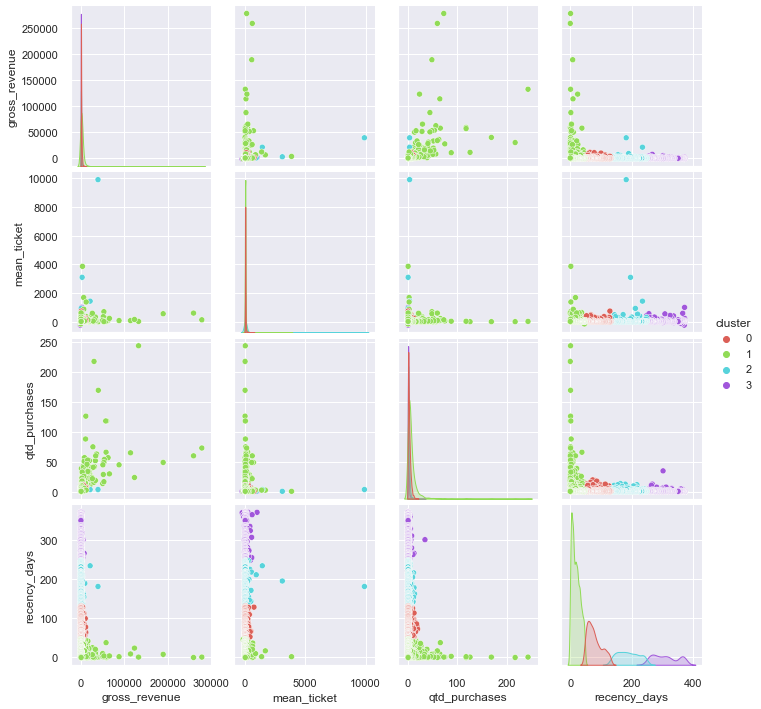

In [88]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster', palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())));

## 9.2 Cluster Profile

In [89]:
# number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id': 'qtd_customers'})
df_cluster['perc_customer'] = df_cluster['qtd_customers'] / (df_cluster['qtd_customers'].sum()) * 100

# gross revenue
df_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_gross_revenue, how='inner', on='cluster')

# mean ticket
df_mean_ticket = df9[['mean_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_mean_ticket, how='inner', on='cluster')

# qtd purchases
df_purchases = df9[['qtd_purchases', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_purchases, how='inner', on='cluster')

# recency days
df_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, how='inner', on='cluster')

In [90]:
df_cluster

,cluster,qtd_customers,perc_customer,gross_revenue,mean_ticket,qtd_purchases,recency_days
0,0,1058,24.25,983.56,29.80,3.08,78.24
1,1,2151,49.31,3087.99,29.30,7.60,17.90
2,2,642,14.72,661.75,51.70,2.21,187.79
3,3,511,11.71,364.07,30.31,1.53,309.04
